<p align="center">
<img align="center" src="https://image.freepik.com/free-photo/physician-noting-down-symptoms-patient_53876-63308.jpg">
</p>

[Image source](https://www.freepik.com/photos/medical)

<h1 style="text-align: center; color:#01872A; font-size: 80px;
background:#daf2e1; border-radius: 20px;
">Simple <br>  Breast Cancer analysis.</h1>

## Please use nbviewer to read this notebook to use all it's features:

https://nbviewer.org/github/sersonSerson/Projects/blob/master/Classification/BreastCancer/BreastCancer.ipynb

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Contents </span>

## 1. [Overview of data.](#step1)
## 2. [Univariate analysis of features](#Step2)
## 3. [Bivariate analysis](#Step3)
## 4. [Model selection.](#Step4)
## 5. [Choosing metric.](#Step5)
## 6. [Fitting model.](#Step6)
## 7. [Feature engineering.](#Step7)
## 8. [Hyperparameter tuning.](#Step8)
## 9. [Metrics analysis.](#Step9)
## 10. [Conclusion.](#Step10)

In [60]:
# Imports.
# Basic libraries
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns

# Sklearn
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, \
    GridSearchCV, cross_val_predict
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler, power_transform
import warnings

In [61]:
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = None

In [62]:
# Configure Matplotlib and seaborn
plt.style.use('seaborn-muted')
sns.set_palette("muted")
plt.rcParams['figure.figsize'] = (16,5);
plt.rcParams['figure.facecolor'] = '#daf2e1'
plt.rcParams['axes.facecolor'] = '#daf2e1'
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['figure.titlesize'] = 30
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['image.cmap']=cm.tab10
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
cmap = cm.tab10
blue = cmap.colors[0]
blue_hex = matplotlib.colors.to_hex(blue)
orange = cmap.colors[1]
orange_hex = matplotlib.colors.to_hex(orange)
green = cmap.colors[2]
green_hex = matplotlib.colors.to_hex(green)

In [63]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [blue, orange,
                                                             green])
matplotlib.cm.register_cmap("mycolormap", cmap)
cpal = sns.color_palette("mycolormap", n_colors=60)

<div id="step1">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1. Overview of data. </span>

In [64]:
df = pd.read_csv('Data/data.csv', index_col='id')

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Get overall statistics of DataFrame (selected features).</h3>

In [65]:
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", [orange, blue],
                                                 N=2)
df_t = df.describe().T
selected_features = ['area_worst', 'perimeter_worst', 'texture_worst',
                     'radius_worst', 'fractal_dimension_worst',
                     'symmetry_worst', 'Unnamed: 32']
selected_columns =  ['count', 'mean', 'max']
df_stats = df_t.loc[selected_features, selected_columns]
df_stats.sort_values('mean', inplace=True, ascending=False)
df_stats.loc['diagnosis'] = [df['diagnosis'].count(), np.nan, np.nan]
df_stats['dtype'] = df[selected_features + ['diagnosis']].dtypes.astype('str')
def background_color(s):
    is_special = s.isin([0, 'object'])
    return [f'background-color: {orange_hex}' if v else '' for v in is_special]
format_dict = {selected_column: "{:10,.2f}" for selected_column in selected_columns}
df_stats.style.apply(background_color).format(format_dict)\
                 .bar(subset=["mean"], color=green_hex)\
                 .bar(subset=["max"], color=blue_hex)

,count,mean,max,dtype
area_worst,569.00,880.58,"4,254.00",float64
perimeter_worst,569.00,107.26,251.20,float64
texture_worst,569.00,25.68,49.54,float64
radius_worst,569.00,16.27,36.04,float64
symmetry_worst,569.00,0.29,0.66,float64
fractal_dimension_worst,569.00,0.08,0.21,float64
Unnamed: 32,0.00,nan,nan,float64
diagnosis,569.00,nan,nan,object


<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;
">Step 1 results:</h2>

### 1. **Feature 'Unnamed: 32' should be removed** as it contains only empty values.
### 2. **Dependent variable is a categorical one (type: object)**, so we need to encode it. The M(malignant) label should be 1 and B(benign) should be 0.
### 3. There are features that have different magnitude (mean values differ, for example, from 0.08 to 880), so we will **need to do scaling for linear models**.
### 4. There are no missing values, so **no imputing needed**.
### 5. The dataset is very small, so no need to divide into the train/validation/test sets, for scoring **standard 5 fold cross-validation** will be used.

In [66]:
df.drop(['Unnamed: 32'], axis=1, inplace=True)
df.sort_index(axis=1, inplace=True)

encoder = LabelEncoder()
df['diagnosis'] = encoder.fit_transform(df['diagnosis'])
encoder_mapping = dict(zip(encoder.classes_,
                           encoder.transform(encoder.classes_)))

<div id="Step2">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 2. Univariate analysis. </span>

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Histogram plots of selected features.</h3>

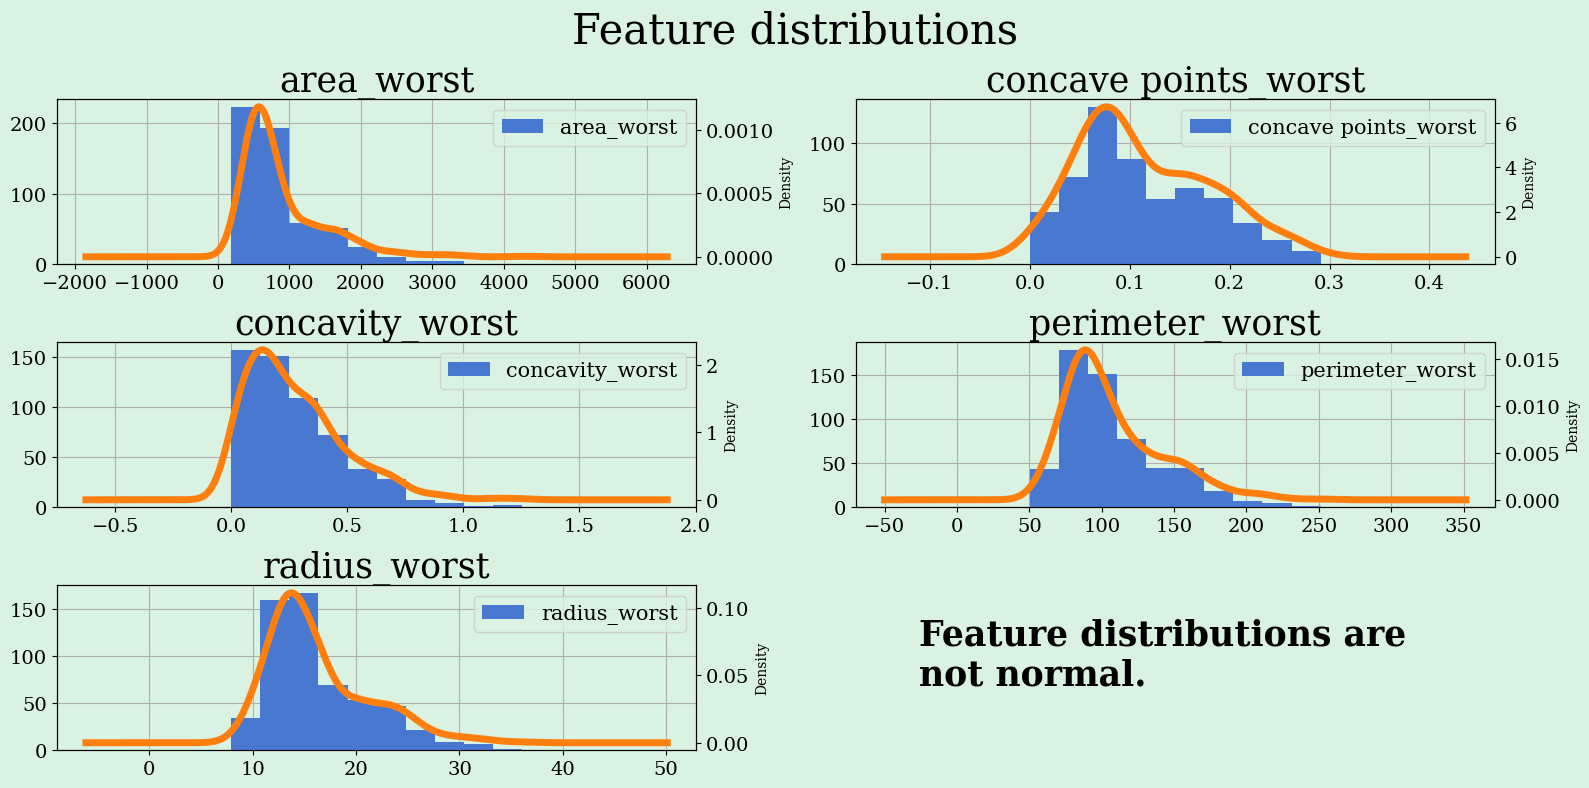

In [67]:
def feature_distibutions(df, log=False):
    columns = ['area_worst', 'concave points_worst', 'concavity_worst',
               'perimeter_worst', 'radius_worst']
    plot_columns = 2
    plot_rows = int(np.ceil(len(columns) / plot_columns))
    fig, axes = plt.subplots(plot_rows, plot_columns, figsize=(16, 8))
    plot_axes = df[columns].hist(ax=axes.ravel()[:len(columns)], legend=True,
                                 zorder=3)
    for ax in plot_axes.ravel():
        ax.legend(prop={'size': 15})
    df[columns].plot(kind='kde', secondary_y=True, subplots=True,
                     ax=axes.ravel()[:len(columns)], color=orange, legend=False)
    last_ax = axes.ravel()[-1]
    last_ax.axis('off')
    if log:
        text = 'Feature distributions seem\na bit closer to normal.'
    else:
        text = 'Feature distributions are\nnot normal.'
    last_ax.text(0.1, 0.4, text,
           transform = last_ax.transAxes, size=25, fontweight='bold')
    plt.suptitle('Feature distributions')
    plt.tight_layout()
    plt.show()
feature_distibutions(df)

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Compare feature distributions of both classes.</h3>


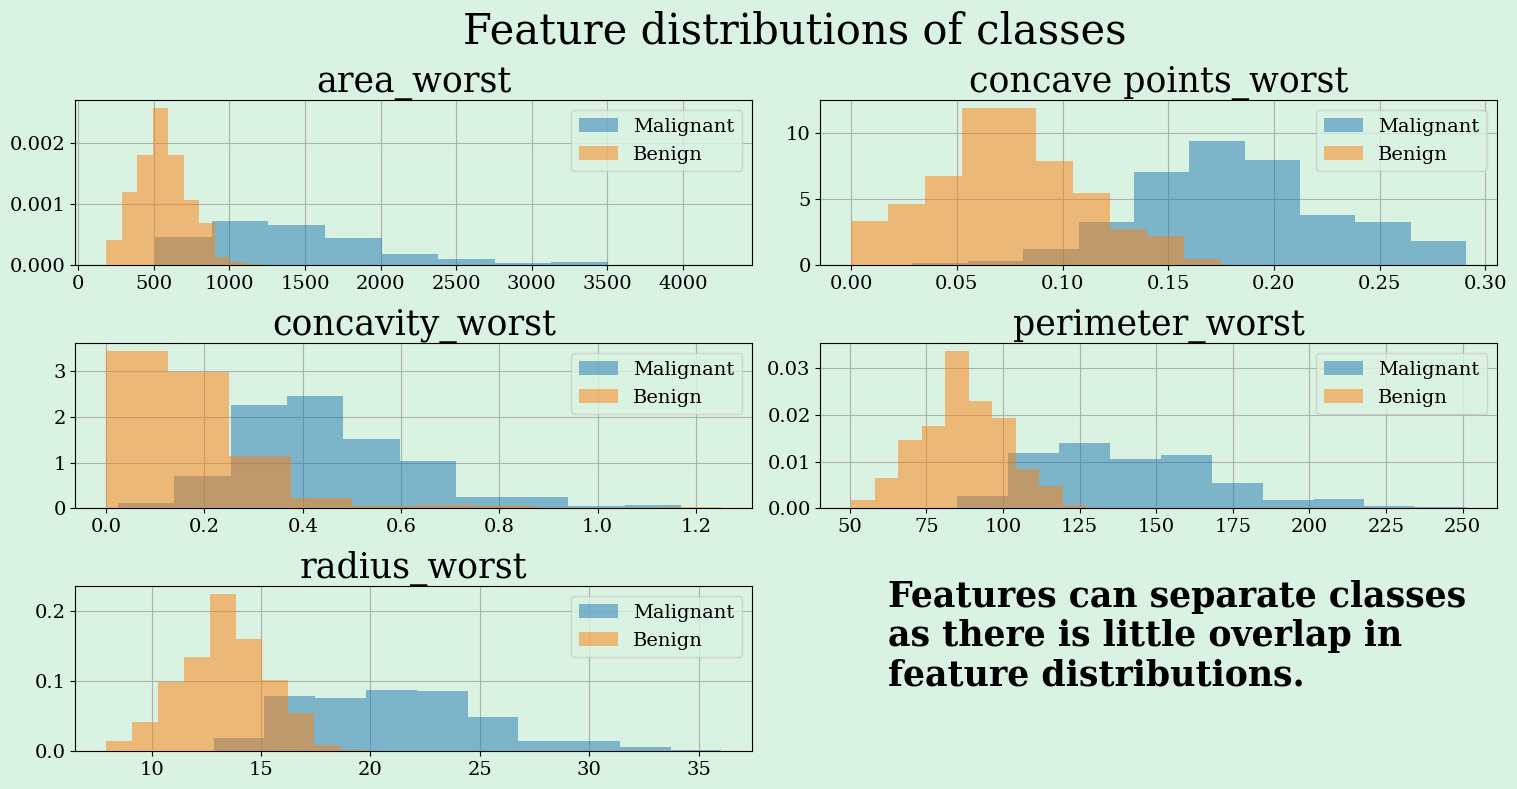

In [68]:
columns = ['area_worst', 'concave points_worst', 'concavity_worst',
           'perimeter_worst', 'radius_worst']
malignant = df[df['diagnosis'] == 1][columns]
benign = df[df['diagnosis'] == 0][columns]
plot_columns = 2
plot_rows = int(np.ceil(len(columns) / plot_columns))
fig, axes = plt.subplots(plot_rows, plot_columns, figsize=(16, 8))
for column, ax in zip(columns, axes.ravel()):
    ax.hist(malignant[column], label='Malignant', density=True, alpha = 0.5,
            color=blue, zorder=3)
    ax.hist(benign[column], label='Benign', density=True, alpha = 0.5,
            color=orange, zorder=3)
    ax.legend(fontsize=14)
    ax.set_title(column)
plt.suptitle('Feature distributions of classes')
last_ax = axes.ravel()[-1]
last_ax.axis('off')
last_ax.text(0.1, 0.4, 'Features can separate classes \nas there is little'
                       ' overlap in\nfeature distributions.',
       transform=last_ax.transAxes, size=25, fontweight='bold')
plt.tight_layout()
plt.show()

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Check dependent variable distributions.</h3>

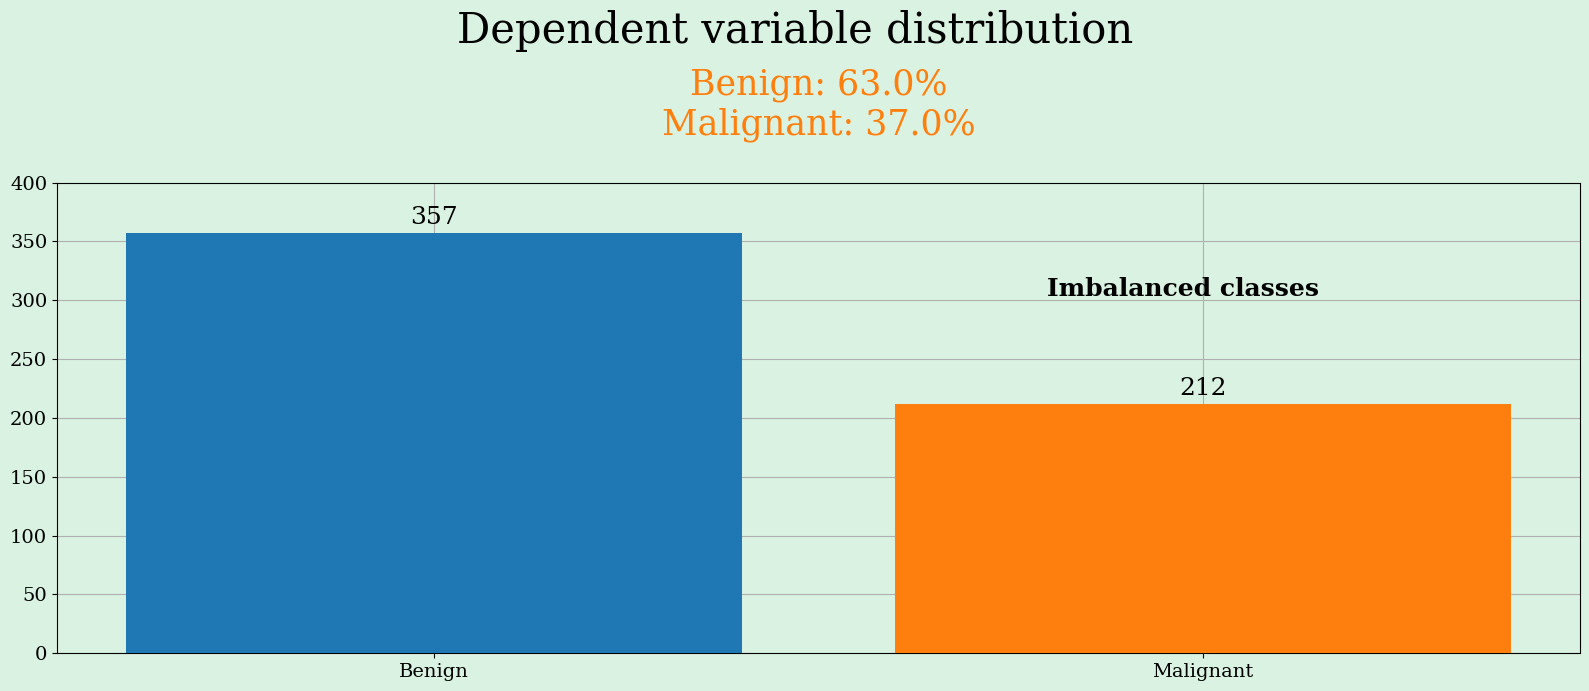

In [69]:
def autolabel(rects, ax, decimals=2):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        value = round(height, decimals)
        ax.annotate('{}'.format(value),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  size=18,# 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
diagnosis_count = df['diagnosis'].value_counts()
diagnosis_percent = \
    df['diagnosis'].value_counts(normalize=True).apply(round, args=(2,))
fig, ax = plt.subplots(figsize=(16, 7))
fig.suptitle('Dependent variable distribution')
rects = ax.bar(diagnosis_count.index, diagnosis_count.values,
               color=[blue, orange], zorder=3)
ax.set_xticks([0, 1])
ax.set_ylim(0, 400)
ax.set_xticklabels(['Benign', 'Malignant'])
ax.set_title(f'Benign: {diagnosis_percent.loc[0] * 100}%\n'
              f'Malignant: {diagnosis_percent.loc[1] * 100}%\n', color=orange)
ax.text(0.65, 0.70, f'Imbalanced classes\n',
             transform = ax.transAxes, size=18, fontweight='bold')
autolabel(rects, ax, decimals=2)
plt.tight_layout()
plt.show()

In [70]:
def update_scores(score_df, modelname, score):
    if modelname not in score_df['ModelName'].values:
        model_dict = dict()
        model_dict['ModelName'] = modelname
        model_dict['Score'] = score
        score_df = score_df.append(model_dict, ignore_index=True)
    return score_df


<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;
">Step 2 results:</h2>

### 1. **The features can distinguish classes**, e.g. 'radius_worst' feature  has very little overlap between classes.
### 2. **We got some skewed distributions**, so it is possible to try to change distributions to improve scoring (power transform).
### 3. **The dependent variable distribution is imbalanced**, so stratification will be useful during cross-validation to balance classes.

<div id="Step3">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 3. Bivariate analysis(analysis of pairs of features). </span>

In [71]:
corr = df.corr()
sorted_index = \
    corr['diagnosis'].apply(np.abs).sort_values(ascending=False).index
sorted_corr = corr[sorted_index].reindex(sorted_index)

most_correlated_index = sorted_corr[(sorted_corr.iloc[:, 0] >= 0.7) |
                                    (sorted_corr.iloc[:, 0] <= -0.7)].index
sorted_corr = sorted_corr.loc[most_correlated_index, most_correlated_index]

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Create the correlation DataFrame and sort it according to the 'Diagnosis'
correlation by absolute values. Choose only correlations with dependent variable with 0.7 or higher or with
 -0.7 or lower.</h3>

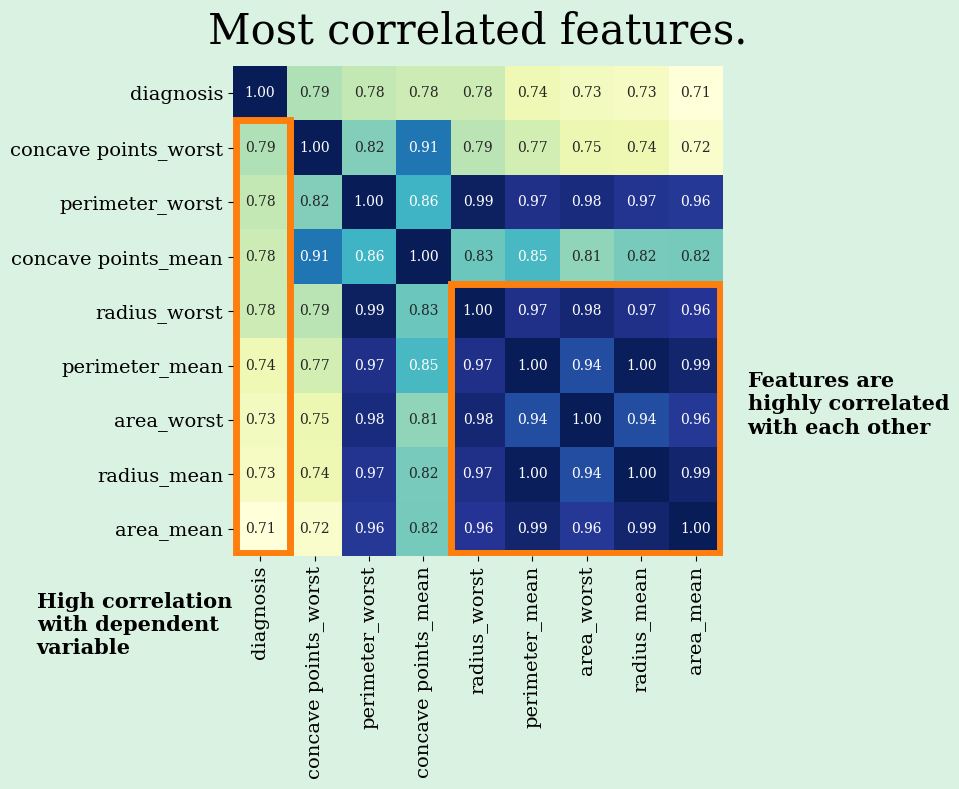

In [72]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(sorted_corr, ax=ax, annot=True, fmt='.2f',
            cmap='YlGnBu',
            cbar=False,
            square=True)
fig.suptitle('Most correlated features.')
rect = patches.Rectangle((4, 4), 4.95, 4.95, linewidth=5, edgecolor=orange,
                         facecolor='none')
ax.add_patch(rect)
ax.text(-0.4, -0.2, 'High correlation\nwith dependent\nvariable',
       transform = ax.transAxes, size=15, fontweight='bold')
rect = patches.Rectangle((0.05, 1), 1, 7.95, linewidth=5, edgecolor=orange,
                         facecolor='none')
ax.add_patch(rect)
ax.text(1.05, 0.25, 'Features are\nhighly correlated\nwith each other',
       transform = ax.transAxes, size=15, fontweight='bold')
plt.tight_layout()
plt.show()

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Pairplots plots for most correlated features.</h3>


In [73]:
columns = ['radius_worst', 'area_worst', 'concave points_worst',
          'perimeter_worst', 'diagnosis']

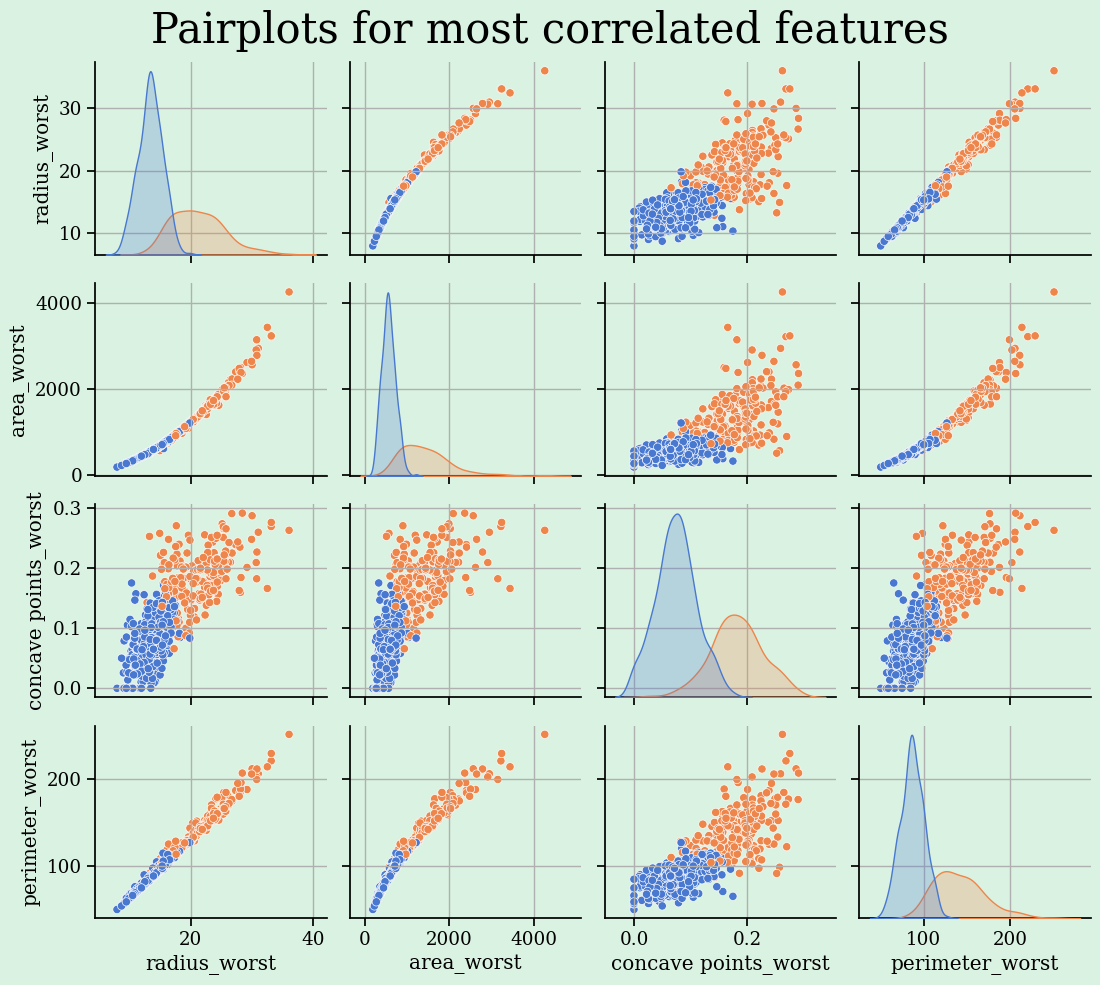

In [74]:
with sns.plotting_context("notebook", font_scale=1.2):
    axes = sns.pairplot(df[columns], hue='diagnosis', )
axes.fig.suptitle('Pairplots for most correlated features')
axes._legend.remove()
plt.tight_layout()
plt.show()

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;
">Step 3 results:</h2>

### 1. **There are some strong feature correlations with dependent variable**. At the same time those features are correlated with each other, e.g. 'concave_points_mean'  and 'concave_points_worst', so **feature selection algorithms can be used**.
### 2. **All the top correlated features are positively correlated** with dependent  variable. The higher value of independent features, more likely the dependent  feature will be 1.

<div id="Step4">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 4. Model selection. </span>

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">To choose between linear and non-liner models perform a check if the
problem may be solved with a linear model with PCA with 2 components.</h3>


In [75]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Standardization before using of PCA
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns,
                        index=X.index)
pca = PCA(n_components=2)
X_tr = pca.fit_transform(X_scaled, y)

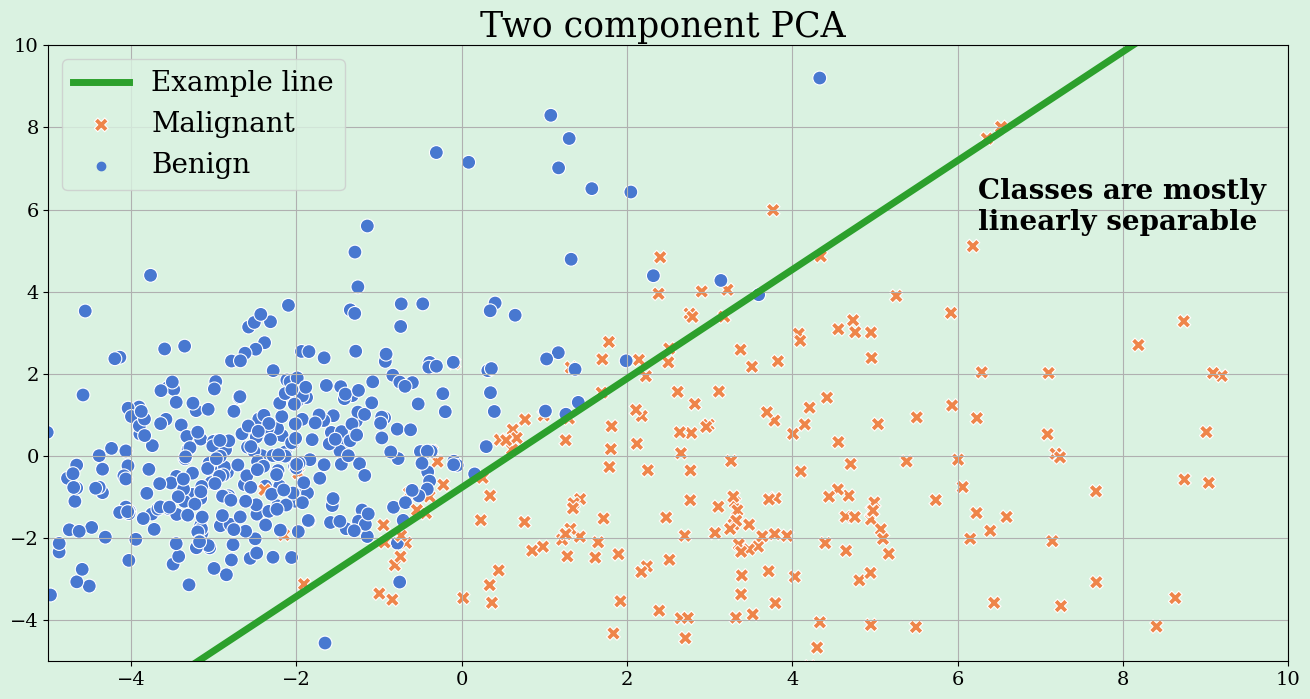

In [76]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(X_tr[:, 0], X_tr[:, 1], hue=y, ax=ax, style=y, s=100)
ax.set_title('Two component PCA ')
ax.plot([-5, 10], [-7.4, 12.5], color=green)
ax.legend(['Example line', 'Malignant', 'Benign'], prop={'size': 20})
ax.set_ylim((-5, 10))
ax.set_xlim((-5, 10))
ax.text(0.75, 0.7, 'Classes are mostly\nlinearly separable',
       transform = ax.transAxes, size=20, fontweight='bold')
plt.show()

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1;border-radius: 20px;
">Step 4 results:</h2>

### 1. Data is **mostly linearly separable**, so linear models could be used. To  keep it simple, basic linear model will be used: LogisticRegression.
### 2. Linear models can probably achieve **good results**.

<div id="Step5">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 5. Choosing metric. </span>

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">As a metric I will use recall, where:</h3>
$
\ \huge{Recall} = \frac {True\ Positives} {True\ Positives\ +\ False\ Negatives}
$
<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Recall shows how good we can identify positive (M(malignant)) cases and immediately start responding to such serious diagnosis.</h3>


<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;
">Step 5 results:</h2>

## 1. **Appropriate** metric selected for model evaluation (Recall).

<div id="Step6">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 6. Fitting model. </span>

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Create model and check its results with both scaled and unscaled data.</h3>

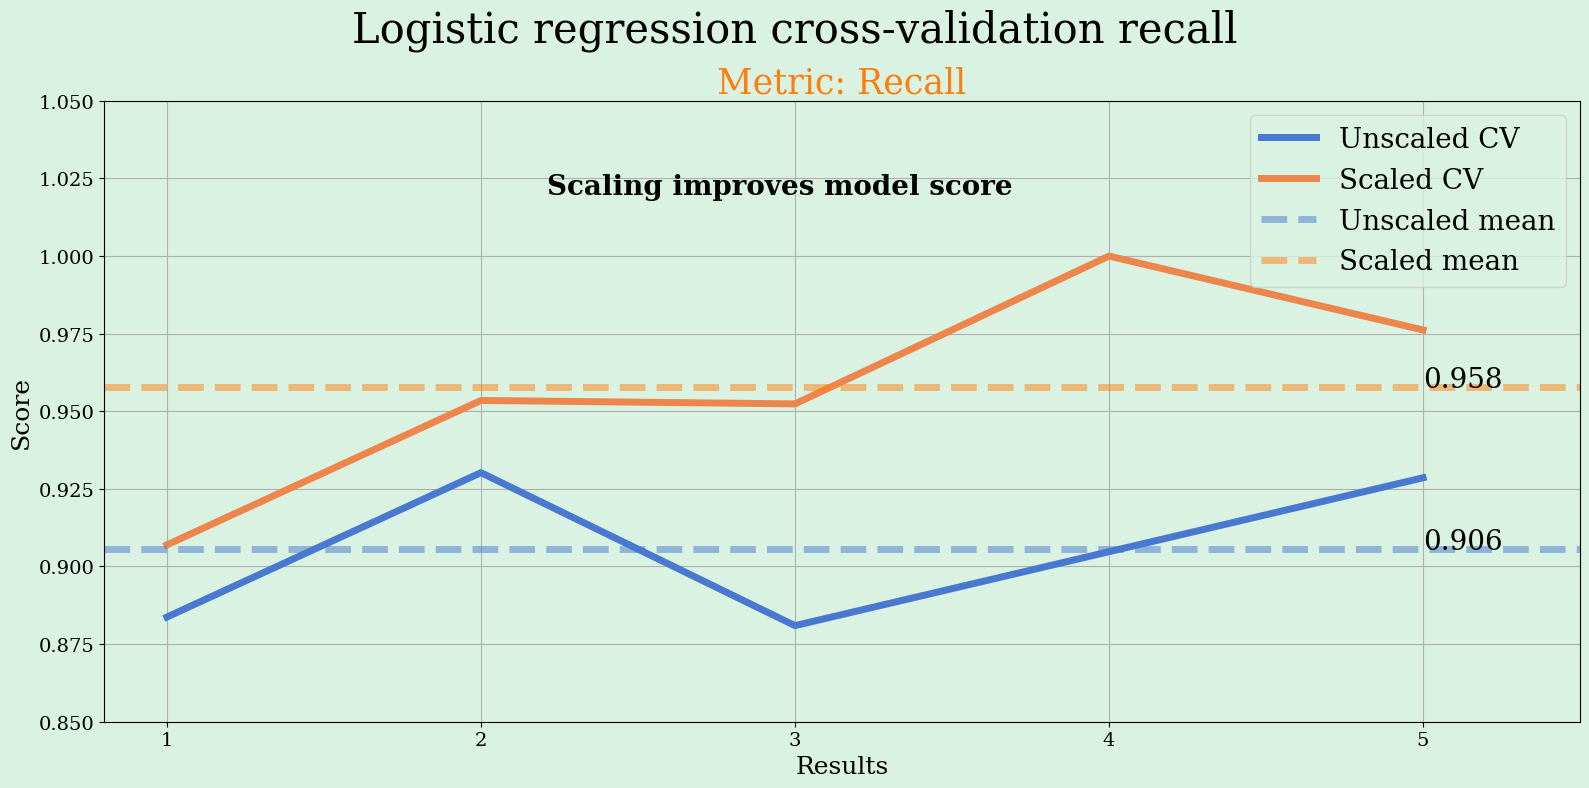

In [77]:
def score_model(model, X_scored, y, scoring):

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    score = cross_val_score(model, X_scored, y, scoring=scoring,
                            cv=skf)
    return score

def compare_scores(score_1, score_2, score_name_1, score_name_2, description):
    score_range = range(1, 6)
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(score_range, score_1, label=f'{score_name_1} CV')
    ax.plot(score_range, score_2, label=f'{score_name_2} CV')
    plt.suptitle('Logistic regression cross-validation recall')
    ax.set_title('Metric: Recall', color=orange, size=25)
    ax.set_ylim([0.85,1.05])
    ax.set_xlim([0.80,5.5])
    ax.set_xlabel('Results')
    ax.set_ylabel('Score')
    ax.set_xticks(score_range)
    score_1_mean = score_1.mean()
    ax.axhline(y=score_1_mean, linestyle='--', label=f'{score_name_1} mean',
               alpha=0.5)
    ax.annotate(format(score_1_mean, '.3f'), xy=(5, score_1_mean), size=20)
    score_2_mean = score_2.mean()
    ax.axhline(y=score_2_mean, linestyle='--', label=f'{score_name_2} mean',
               color=orange, alpha=0.5)
    ax.annotate(format(score_2_mean, '.3f'), xy=(5,score_2_mean), size=20)
    ax.legend(loc='best', prop={'size': 20})
    ax.text(0.3, 0.85, description,
       transform = ax.transAxes, size=20, fontweight='bold')
    ax.set_xlabel('Results', fontsize=18)
    ax.set_ylabel('Score', fontsize=18)
    plt.tight_layout()
    plt.show()

unscaled_recall = score_model(LogisticRegression(random_state=0), X, y,
                              'recall')
scaled_recall = score_model(LogisticRegression(random_state=0), X_scaled, y,
                            'recall')
description = 'Scaling improves model score'
compare_scores(unscaled_recall, scaled_recall, 'Unscaled', 'Scaled', description)

In [78]:
# Create a DataFrame with scores
score_df = pd.DataFrame(columns=['ModelName', 'Score'])
score_df = update_scores(score_df, 'Baseline', unscaled_recall.mean())
score_df = update_scores(score_df, 'Scaled features', scaled_recall.mean())

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;
">Step 6 results:</h2>

### 1. **Logistic Regression shows pretty good results**: we get over 91% of the Malignant cases right with raw features.
### 2. **Model fitted with scaled features performs better** than model with raw  features. Recall raises from 91,5% to 96%.

<div id="Step7">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 7. Improving performance with feature engineering. </span>

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">To improve performance we can try following ideas:</h3>

### 1. Feature selection techniques.
### 2. Power transform the data to make distributions more Gaussian.

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Feature selection based on feature importance.

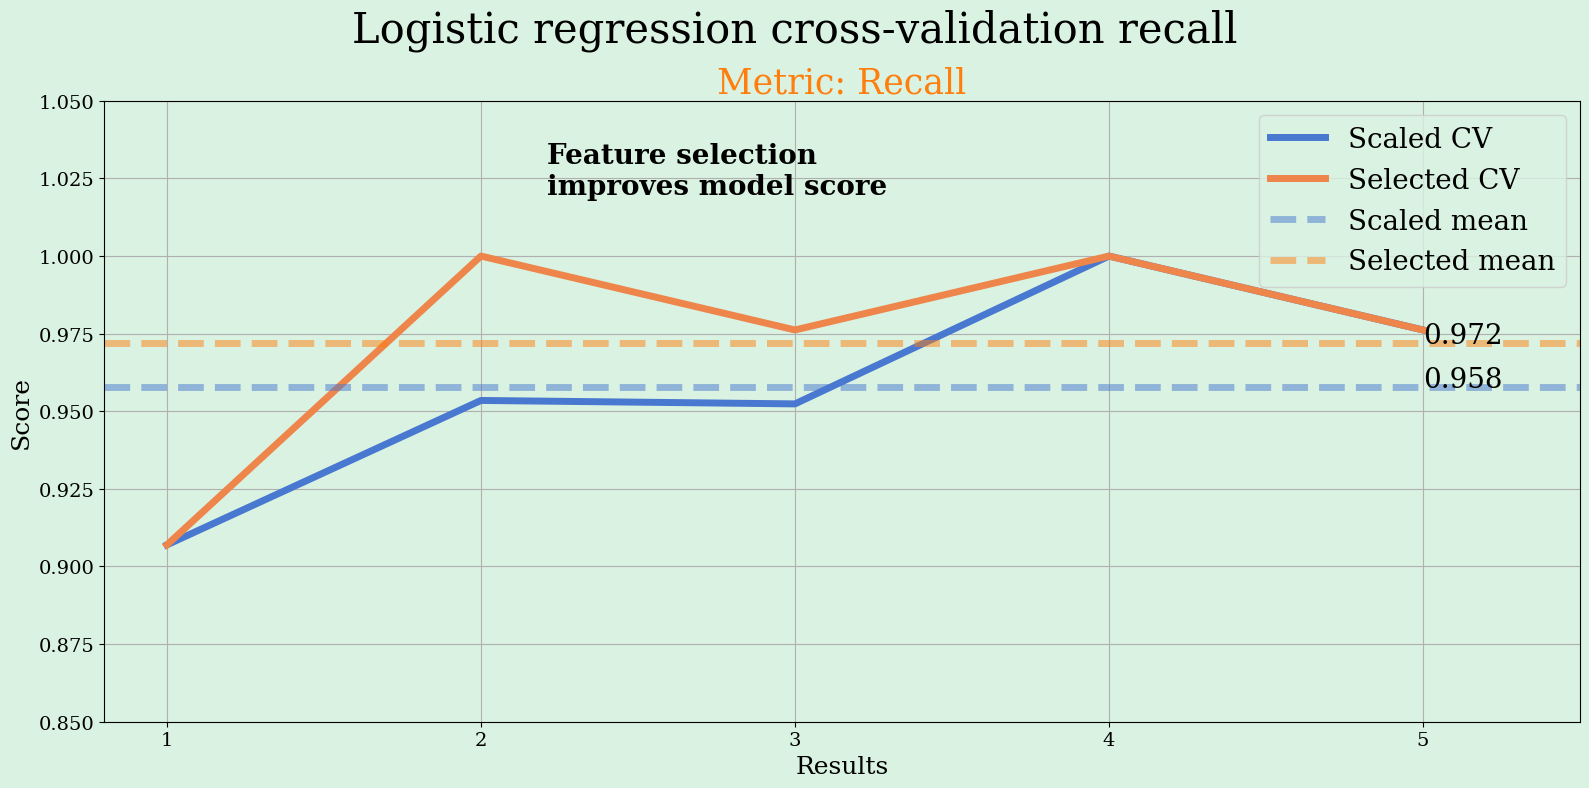

In [79]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
rfecv = RFECV(LogisticRegression(random_state=0), cv=skf, scoring='recall').fit\
    (X_scaled, y)
used_features = rfecv.get_support()
X_scaled_rfe = X_scaled.loc[:, used_features]
selected_recall = \
    score_model(LogisticRegression(random_state=0), X_scaled_rfe, y, 'recall')
description = 'Feature selection\nimproves model score'
compare_scores(scaled_recall, selected_recall, 'Scaled', 'Selected', description)
score_df = update_scores(score_df, 'Feature selection + Scaling',
                       selected_recall.mean())

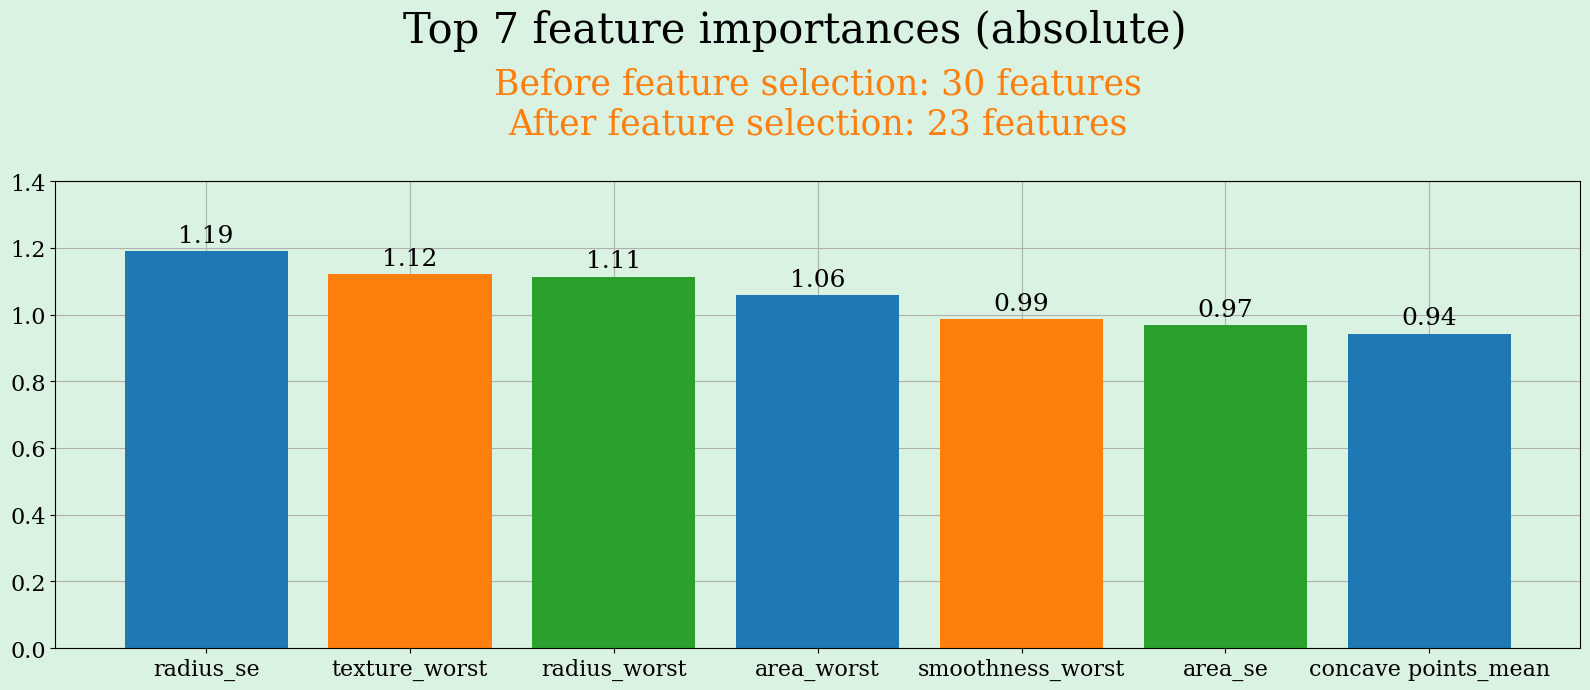

In [80]:
features = \
    pd.Series(rfecv.estimator_.coef_[0], index=X_scaled.columns[used_features])
features = features.apply(np.abs).sort_values(ascending=False)[:7]

fig, ax = plt.subplots(figsize=(16, 7))
rects = ax.bar(x=features.index, height=features,
               zorder=2, color=[blue, orange, green])
autolabel(rects, ax, decimals=2)
plt.suptitle('Top 7 feature importances (absolute)')
ax.set_title(f'Before feature selection: {len(X_scaled.columns)} features\n'
             f'After feature selection: {len(X_scaled_rfe.columns)} '
             f'features\n',
             color=orange)
ax.set_ylim(0.0, 1.40)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.show()

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Power transform the data</h3>


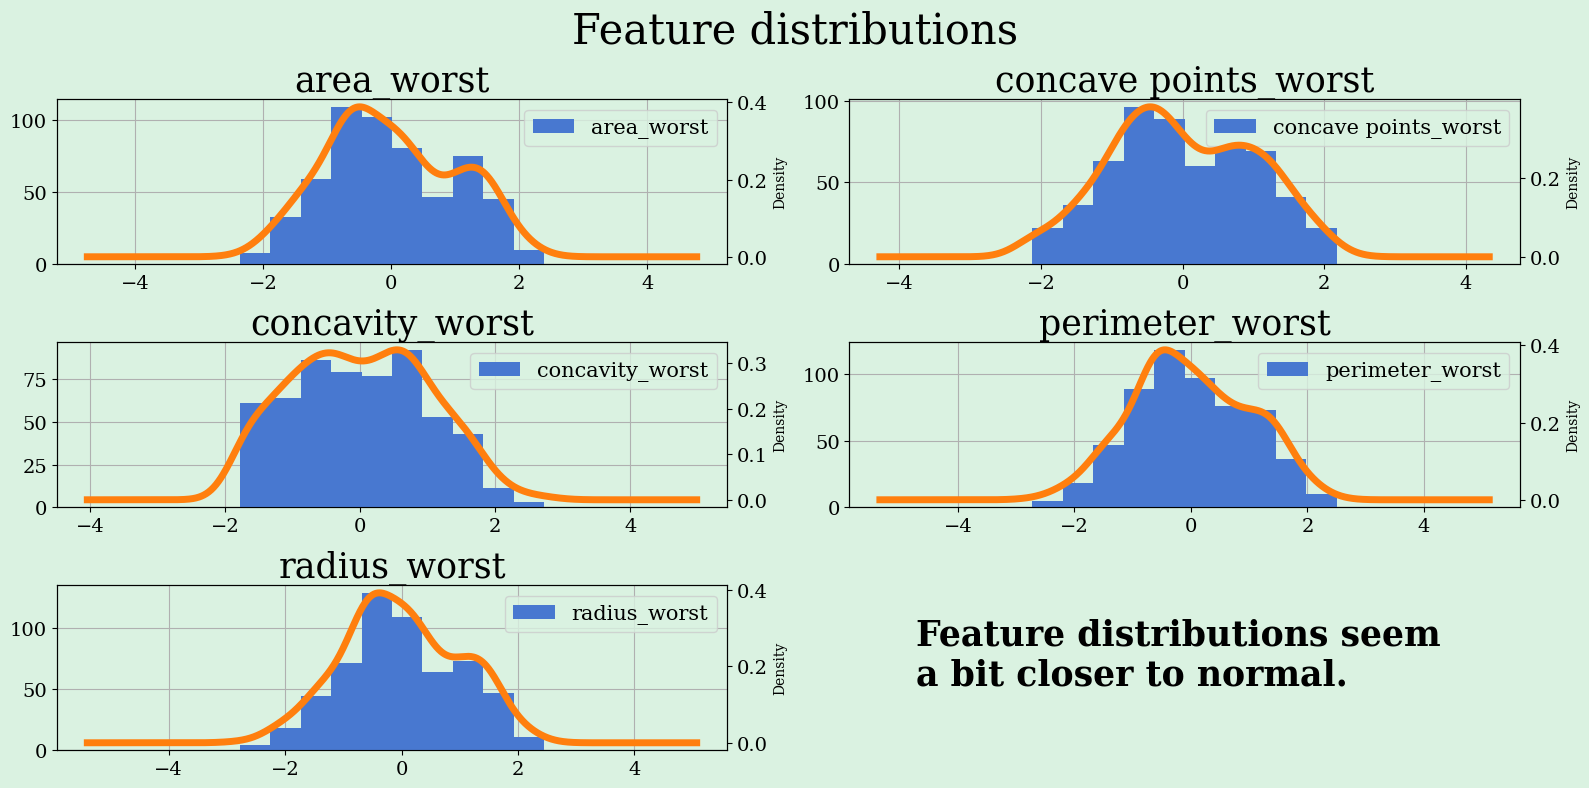

In [81]:
X_power_transform \
    = pd.DataFrame(power_transform(X_scaled_rfe, standardize=True),
                   columns=X_scaled_rfe.columns, index=X_scaled_rfe.index)
feature_distibutions(X_power_transform, log=True)

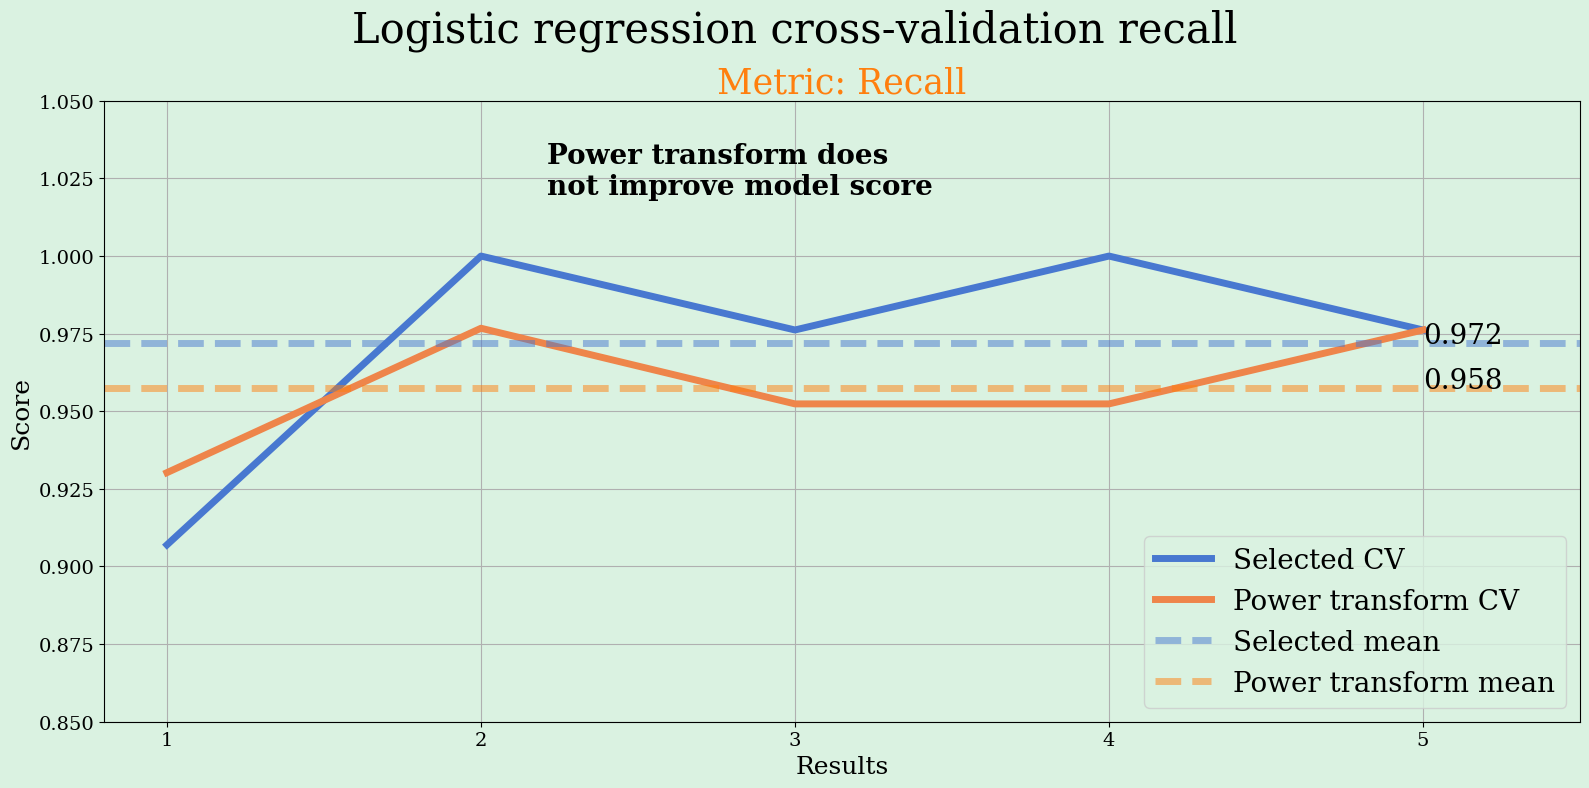

In [82]:
power_transform_recall = \
    score_model(LogisticRegression(random_state=0), X_power_transform, y, 'recall')
description = 'Power transform does\nnot improve model score'
compare_scores(selected_recall, power_transform_recall, 'Selected',
               'Power transform', description);
score_df = update_scores(score_df, 'Power transform', power_transform_recall
                         .mean())

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;
">Step 7 results:</h2>

### 1. **Feature selection improves score** from 96% to 97% and reduces dataset from  30 features to 23 features.
### 2. **Power transform doesn't give any score improvements**.


<div id="Step8">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 8. Improving performance with hyperparameter tuning. </span>

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Define the grid and use GridSearch to find the best parameters.</h3>


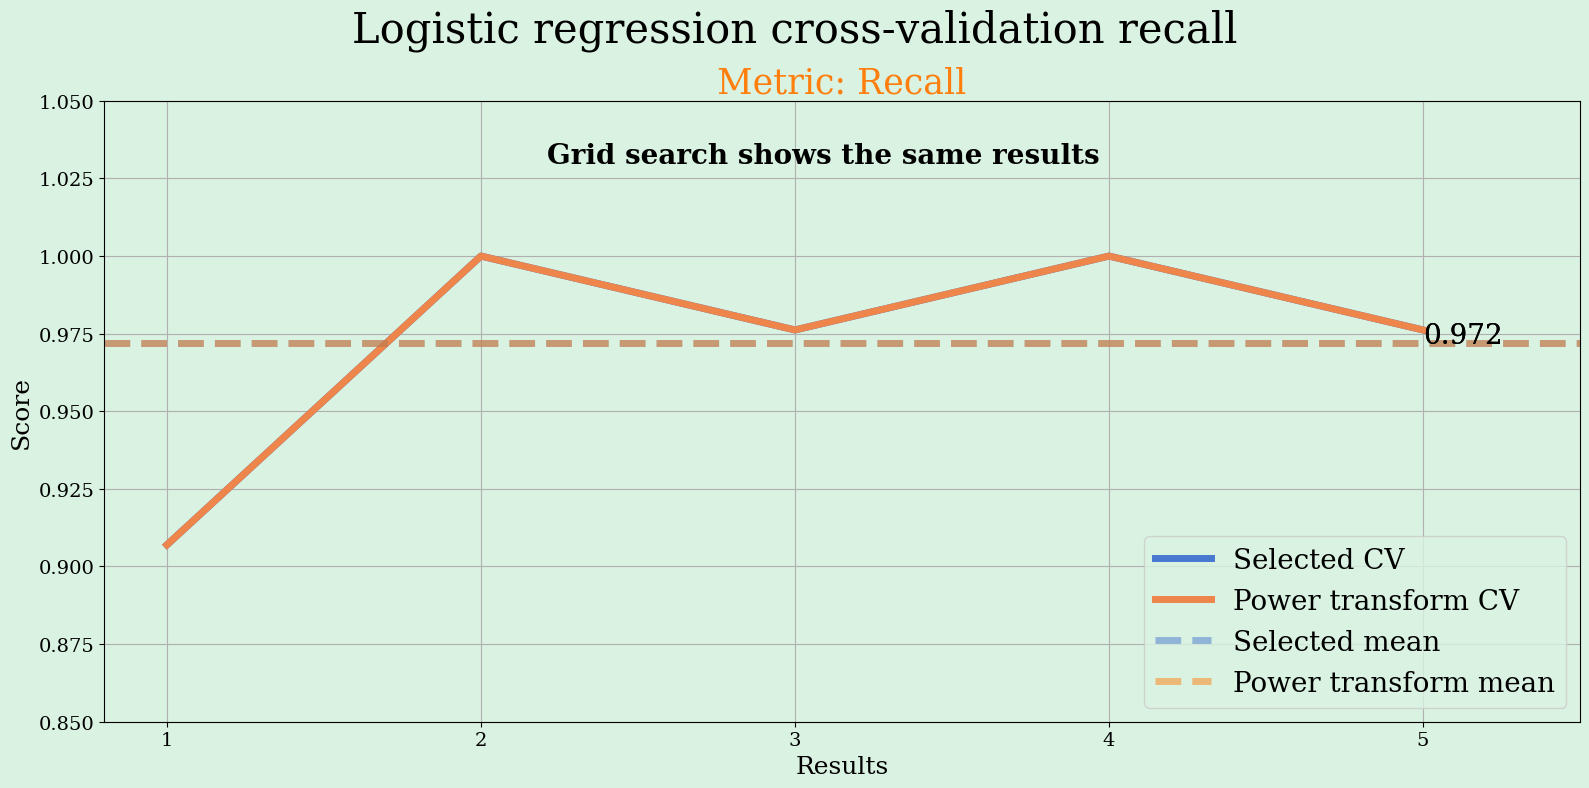

In [83]:
grid = {'penalty': ['l2', 'l1'],
        'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
        'C': [0.0001, 0.01, 0.01, 0.1, 0.8, 1, 1.2, 10, 100, 1000],
        }

grid_search =\
    GridSearchCV(estimator=LogisticRegression(random_state=0, n_jobs=-1),
                 param_grid=grid, scoring='recall', n_jobs=-1,
                 cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0))
grid_search.fit(X_scaled_rfe, y)
best_params = grid_search.best_params_
grid_search_score = \
    score_model(LogisticRegression(n_jobs=-1, random_state=0, **best_params),
                X_scaled_rfe, y, scoring='recall')
description = 'Grid search shows the same results\n'
compare_scores(selected_recall, grid_search_score, 'Selected',
               'Power transform', description);
transformed_dict = {'ModelName': 'Grid search',
               'Score': grid_search.best_score_}

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;
">Step 8 results:</h2>

### 1. **GridSearch CV doesn't make the results better** with current model.

<div id="Step9">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 9. Metrics analysis. </span>

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Basic statistics, confusion matrix, ROC Curve.</h3>

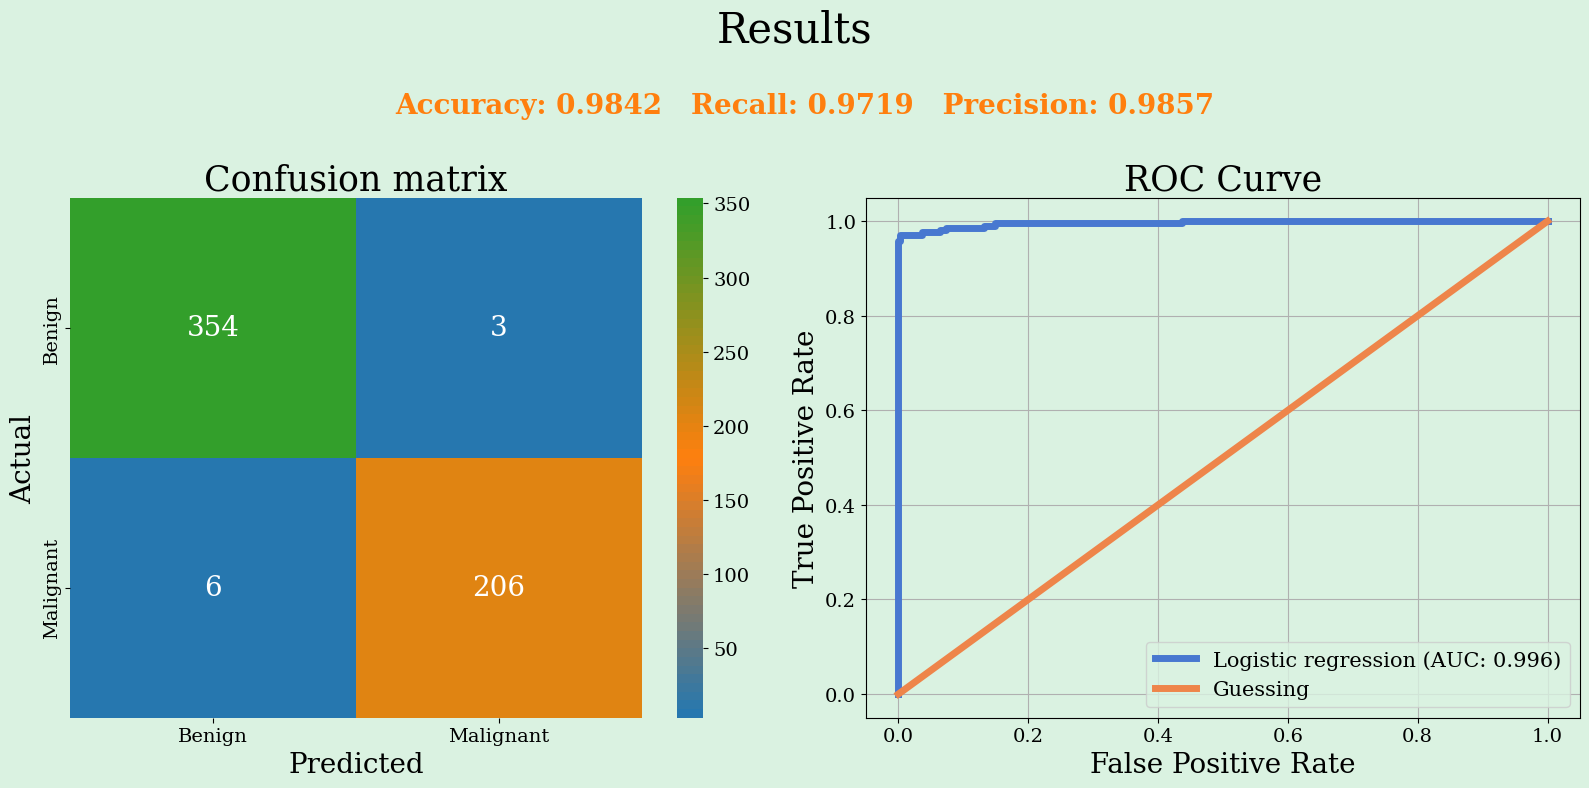

In [84]:
def results_plot(model, X, y):
    fig = plt.figure(figsize=(16, 8))
    layout = (1, 2)
    cm_ax = plt.subplot2grid(layout, (0, 0))
    roc_ax = plt.subplot2grid(layout, (0, 1))

    scoring_metrics = ['accuracy', 'recall', 'precision']
    title = ''
    for metric in scoring_metrics:
        score = score_model(model, X_scaled_rfe, y, scoring=metric).mean()
        title += f'{metric.capitalize()}: {round(score, 4)}   '
    plt.suptitle('Results\n\n')
    fig.text(0.25, 0.85, title,
             transform=fig.transFigure, size=20, fontweight='bold', color=orange)
    predictions = cross_val_predict(model, X, y, cv=skf)
    conf = confusion_matrix(y, predictions)
    sns.heatmap(conf, annot=True, fmt='.0f', ax=cm_ax,
                cmap=cpal,
                xticklabels=['Benign', 'Malignant'],
                annot_kws={'fontsize': 20})
    cm_ax.set_yticklabels(['Benign', 'Malignant'], va='center')
    cm_ax.set_xlabel('Predicted', size=20)
    cm_ax.set_ylabel('Actual', size=20)
    cm_ax.set_title('Confusion matrix')

    y_probs = cross_val_predict(LogisticRegression(random_state=0), X_scaled_rfe, y,
                          method='predict_proba', cv=skf)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_probs)
    roc_auc = auc(fpr, tpr)
    roc_ax.plot(fpr, tpr, label=f'Logistic regression (AUC: {round(roc_auc, 3)})')
    roc_ax.plot([0, 1], [0, 1], label='Guessing')
    roc_ax.set_title('ROC Curve')
    roc_ax.set_xlabel('False Positive Rate', size=20)
    roc_ax.set_ylabel('True Positive Rate', size=20)
    roc_ax.legend(loc='best', prop={'size': 15})
    plt.tight_layout()
    plt.show()

model = LogisticRegression(random_state=0)
results_plot(model, X_scaled_rfe, y)

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Prediction analysis.</h3>

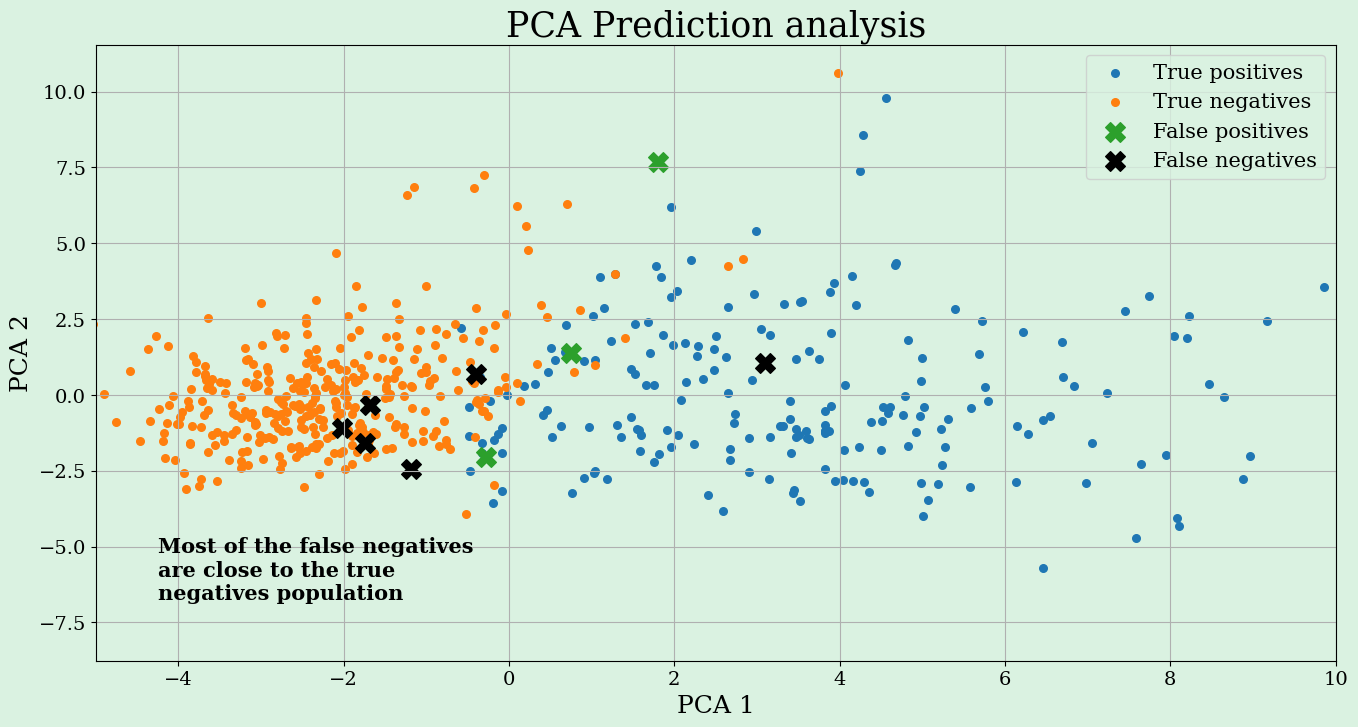

In [85]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
y_pred = cross_val_predict(model, X_scaled_rfe, y, cv=skf)
true_positive_mask = ((y == y_pred) & (y.isin([1])))
true_negative_mask = ((y == y_pred) & (y.isin([0])))
false_positive_mask = ((y != y_pred) & (y.isin([0])))
false_negative_mask = ((y != y_pred) & (y.isin([1])))

fig, ax = plt.subplots(figsize=(16, 8))
pca = PCA(n_components=2)
X_pca = pd.DataFrame(pca.fit_transform(X_scaled_rfe, y),
                    columns=['PCA1', 'PCA2'], index=X_scaled_rfe.index)

ax.scatter(X_pca.loc[true_positive_mask, 'PCA1'],
           X_pca.loc[true_positive_mask, 'PCA2'],
           color=blue, marker='.', label='True positives', s=120)
ax.scatter(X_pca.loc[true_negative_mask, 'PCA1'],
           X_pca.loc[true_negative_mask, 'PCA2'],
           color=orange, marker='.', label='True negatives', s=120)
ax.scatter(X_pca.loc[false_positive_mask, 'PCA1'],
           X_pca.loc[false_positive_mask, 'PCA2'],
           color=green, marker='X', label='False positives', s=200)
ax.scatter(X_pca.loc[false_negative_mask, 'PCA1'],
           X_pca.loc[false_negative_mask, 'PCA2'],
           c='black', marker='X', label='False negatives', s=200)
ax.text(0.05, 0.10, 'Most of the false negatives\n'
                    'are close to the true\n'
                    'negatives population',
        transform = ax.transAxes, size=15, fontweight='bold')
ax.set_title('PCA Prediction analysis')
ax.set_xlim((-5, 10))
ax.set_xlabel('PCA 1', fontsize=18)
ax.set_ylabel('PCA 2', fontsize=18)
ax.legend(prop={'size': 15})
plt.show()

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;
">Step 9 results:</h2>

### 1. **Most of false negative predictions seem to be very close to negative value**  population, so it seems to be impossible to improve recall with current feature set and current model.
### 2. **Overall results are good enough with current model**.

<div id="Step10">
</div>

<div id="step1">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 10. Conclusion. </span>

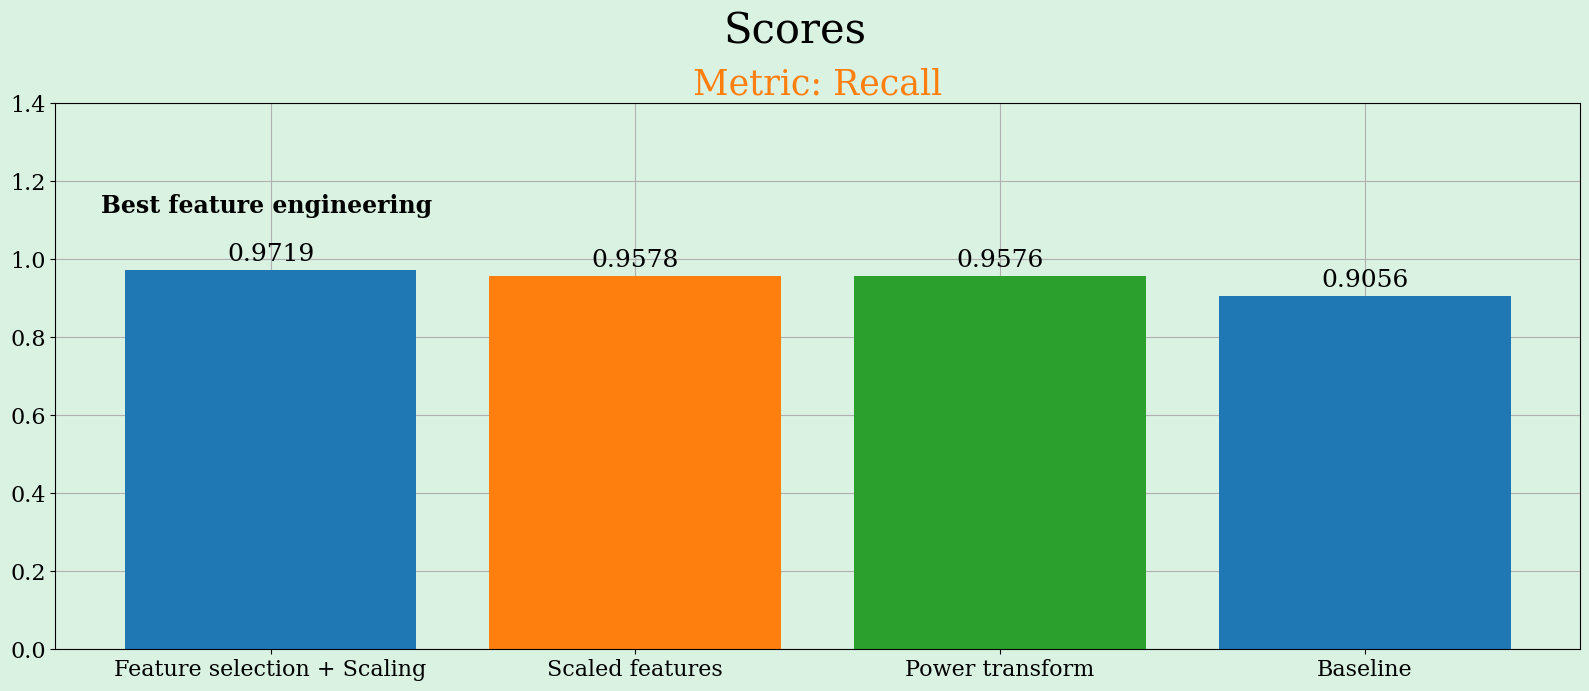

In [86]:
fig, ax = plt.subplots(figsize=(16, 7))
score_df.sort_values(['Score'], inplace=True, ascending=False)
rects = ax.bar(x=score_df['ModelName'], height=score_df['Score'],
               zorder=2, color=[ blue, orange, green])
autolabel(rects, ax, decimals=4)
plt.suptitle('Scores')
ax.set_title('Metric: Recall', color=orange)
ax.set_ylim(0.0, 1.40)
ax.text(0.03, 0.8, 'Best feature engineering',
        transform = ax.transAxes, size=17, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.show()

### 1. Logistic regression shows good results on this dataset even if used on raw features.
### 2. Feature selection + feature scaling allows to create a prediction which is sufficiently better than a baseline.

<h3 style="padding: 10px; text-align: left; color:#01872A; font-size: 20px;
">Further analysis.</h3>

### 1. **Use non-linear models**: K-Nearest Neighbours, Random Forest, SVM, Gradient Boosting.
### 2. **Use wider feature engineering** to distinguish False Negatives.

<h2 style="padding: 30px; text-align: center; color:#01872A; font-size: 40px;
background:#daf2e1; border-radius: 20px;">
Thank you for reading.<br> Any feedback is highly appreciated. </h2>